In [1]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [29]:
batch_size = 512

transform_image = transforms.Compose([transforms.ToTensor(),])

trainset = FashionMNIST('/tmp/data', download=True, transform=transform_image, train=True)
testset  = FashionMNIST('/tmp/data', download=True, transform=transform_image, train=False)
train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=10, shuffle=True)
test_loader  = DataLoader(testset, batch_size=batch_size, num_workers=5, shuffle=True)

In [25]:
class Encoder(nn.Module):
    def __init__(self, latent_size=25, hidden_size=512):
        super(Encoder, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(1),
            nn.Linear(128*16*16, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size),
            nn.ReLU()
        )
  

    def forward(self, x):
        x = self.main(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_size=25, hidden_size=512):
        super(Decoder, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 128*16*16),
            nn.Unflatten(-1, (128, 16, 16)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=5),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, latent_size=25):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(latent_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [26]:
def to_image(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [33]:
number_epochs = 51
learning_rate = 1e-4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Autoencoder(32)
model = model.to(device)

#criterion = nn.MSELoss()
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_loss = []
test_loss = []

In [34]:
with tqdm(range(number_epochs)) as iterator:
    for epoch in iterator:
        running_loss = 0
        count = 0
        for data in train_loader:
            optimizer.zero_grad()
            
            image, i = data
            image = image.to(device)
  
            # Forward pass
            output = model(image)
            loss = criterion(output, image)

            # Backward pass
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            count += 1
        train_loss.append(running_loss/count)
        
        with torch.no_grad():
            running_loss = 0
            count = 0
            for data in test_loader:
                image, i = data
                image = image.to(device)

                # Forward pass
                output = model(image)
                loss = criterion(output, image)
                running_loss += loss.item()
                count += 1
            test_loss.append(running_loss/count)
                
            iterator.set_postfix_str(f"Train Loss: {train_loss[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}")
            if epoch % 10 == 0:
                rec = to_image(output.cpu().data)
                img = to_image(image.cpu().data)
                save_image(rec, f"rec_{epoch}.png")
                save_image(img, f"img_{epoch}.png")

  0%|          | 0/51 [00:00<?, ?it/s]

[]

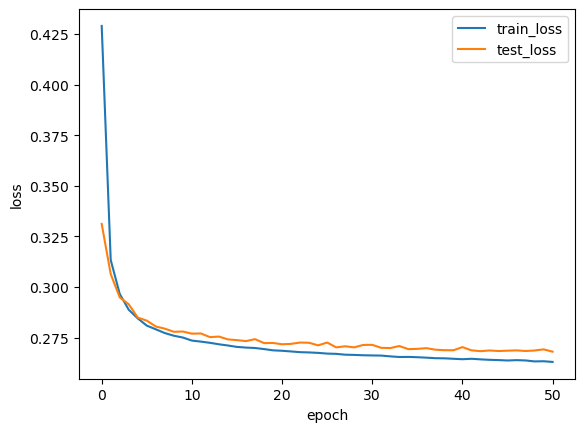

In [35]:
plt.plot(range(len(train_loss)), train_loss, label="train_loss")
plt.plot(range(len(test_loss)), test_loss, label="test_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot()

In [41]:
class Encoder(nn.Module):
    def __init__(self, latent_size=25, hidden_size=512):
        super(Encoder, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(1),
            nn.Linear(128*16*16, hidden_size),
            nn.ReLU()
        )
        self.mu = nn.Linear(hidden_size, latent_size)
        self.logvar = nn.Linear(hidden_size, latent_size)

    def forward(self, x):
        x = self.main(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar
    
class Decoder(nn.Module):
    def __init__(self, latent_size=25, hidden_size=512):
        super(Decoder, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 128*16*16),
            nn.Unflatten(-1, (128, 16, 16)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=5),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_size=64):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(latent_size)
        
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_().to(device)
        #eps = Variable(eps)
        return eps.mul(std).add_(mu)
        
    def forward(self, x):
        mu, logvar = self.encoder(x)
        x = self.reparametrize(mu, logvar)
        x = self.decoder(x)
        return x, mu, logvar

Variante ohne CNN:

In [36]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, device=None):
        super(VariationalAutoencoder, self).__init__()

        if device is None:
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.device = device
        
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode_function(self, x):
        x = x.view(image.size(0), -1)
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_().to(device)
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode_function(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3)).view(h3.size(0), 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode_function(x)
        z = self.reparametrize(mu, logvar)
        return self.decode_function(z), mu, logvar

In [42]:
class KLDLoss(nn.Module):
    """Calculate Kullback-Leibler divergence between learned mean and logvar and standard normal distribution.
    This is *NOT* a re-implementation of torch.nn.KLDivLoss"""
    def __init__(self, reduction='mean'):
        super(KLDLoss, self).__init__()
        self.reduction = reduction

    def forward(self, mean, logvar):
        # KLD loss
        kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), 1)
        # Size average
        if self.reduction == 'mean':
            kld_loss = torch.mean(kld_loss)
        elif self.reduction == 'sum':
            kld_loss = torch.sum(kld_loss)
        return kld_loss

In [46]:
number_epochs = 51
learning_rate = 1e-3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

beta = 0.01

model = VariationalAutoencoder(32)
model = model.to(device)

reconstruction_loss = nn.MSELoss(reduction="sum")
kld_loss = KLDLoss(reduction="sum")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_loss = []
test_loss = []

In [47]:
with tqdm(range(number_epochs)) as iterator:
    for epoch in iterator:
        running_loss = 0
        count = 0
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            
            image, i = data
            image = image.to(device)
  
            # Forward pass
            output, mean, logvar = model(image)
            rc_loss = reconstruction_loss(output, image)
            kl_loss = kld_loss(mean, logvar)
            loss = rc_loss + beta * kl_loss

            # Backward pass
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            count += 1
        train_loss.append(running_loss/count)
        
        with torch.no_grad():
            running_loss = 0
            count = 0
            for data in test_loader:
                image, i = data
                image = image.to(device)

                # Forward pass
                output, mean, logvar = model(image)
                rc_loss = reconstruction_loss(output, image)
                kl_loss = kld_loss(mean, logvar)
                loss = rc_loss + beta * kl_loss
                running_loss += loss.item()
                count += 1
            test_loss.append(running_loss/count)
                
            iterator.set_postfix_str(f"Train Loss: {train_loss[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}")
            if epoch % 10 == 0:
                rec = to_image(output.cpu().data)
                img = to_image(image.cpu().data)
                save_image(rec, f"rec_{epoch}.png")
                save_image(img, f"img_{epoch}.png")

  0%|          | 0/51 [00:00<?, ?it/s]

[]

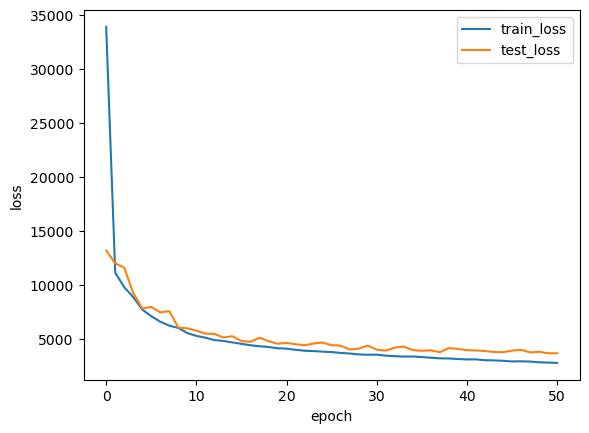

In [48]:
plt.plot(range(len(train_loss)), train_loss, label="train_loss")
plt.plot(range(len(test_loss)), test_loss, label="test_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot()